In [1]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"

from typing import Tuple
import jax
import jax.numpy as jnp
import numpy as np
%load_ext autoreload
%autoreload 2

from src.models.base import ModelConfig
from src.models.rnn import ElmanRNN, LSTM, UnitaryRNN
from src.models.lru import LinearRecurrentUnit
from src.data.copy_dataset import CopyDataset

Array = jnp.ndarray


In [3]:
def _jacobian_lookback_frobenius(
    jac_diags: Array,
    wh_weight: Array,
    mask: Array,
) -> Array:
    """Compute M(T) = ||J_t * J_{t-1} * ... * J_{t-T+1}||_F for each time step t and lookback T.

    For time step t, computes jacobian norms for all possible lookback windows:
    - lag=0: identity matrix (norm = sqrt(H))
    - lag=1: ||J_t||_F
    - lag=2: ||J_t * J_{t-1}||_F
    - lag=T: ||J_t * J_{t-1} * ... * J_0||_F

    Args:
        jac_diags: Jacobian diagonals [B, T, H]
        wh_weight: Hidden-to-hidden weight matrix [H, H]
        mask: Sequence mask [B, T]

    Returns:
        Array of shape [B, T, T+1] where output[b, t, lag] = M(lag) at time t
    """
    B, T, H = jac_diags.shape
    wh = wh_weight.astype(jac_diags.dtype)
    diag_seq = jnp.swapaxes(jac_diags, 0, 1)  # [T, B, H]
    mask_seq = jnp.swapaxes(mask, 0, 1)  # [T, B]

    # Identity matrix norm (for lag=0)
    identity_norm = jnp.sqrt(jnp.array(H, dtype=wh.dtype))
    eye = jnp.broadcast_to(jnp.eye(H, dtype=wh.dtype), (B, H, H))

    # Initialize output array [B, T, T+1]
    all_norms = jnp.zeros((B, T, T + 1), dtype=wh.dtype)

    def scan_step(carry, inputs):
        """Process one time step, computing all lookback norms.
        
        carry: (jacobian_history [B, T, H, H], norms [B, T, T+1])
        inputs: (diag_t, mask_t, t_idx) where t_idx is the current time step
        """
        diag_t, mask_t, t_idx = inputs
        jacobian_history, norms = carry
        
        # Compute J_t for this time step
        J_t = diag_t[:, :, None] * wh[None, :, :]  # [B, H, H]
        mask_bool = mask_t > 0.0
        
        # Update jacobian history: shift and prepend J_t
        jacobian_history = jnp.concatenate([J_t[:, None, :, :], jacobian_history[:, :-1, :, :]], axis=1)
        
        # Collect norms for all lags at this time step
        time_step_norms = jnp.zeros((B, T + 1), dtype=wh.dtype)
        time_step_norms = time_step_norms.at[:, 0].set(identity_norm)  # lag=0: identity
        
        # Compute norms for lags 1 to t_idx+1 using fori_loop
        # We'll compute up to T+1 and mask invalid lags
        def compute_lag_norm(lag, carry_state):
            J_cumulative, norms_array = carry_state
            # Only compute if lag <= t_idx + 1
            valid_lag = lag <= (t_idx + 1)
            # Get J_{t-lag+1} from history (most recent is at index 0)
            hist_idx = lag - 1
            J_hist = jacobian_history[:, hist_idx, :, :]  # [B, H, H]
            # Multiply cumulative by this jacobian (going backwards in time)
            J_cumulative = jnp.einsum("bij,bjk->bik", J_hist, J_cumulative)
            # Apply mask
            J_cumulative = jnp.where(mask_bool[:, None, None], J_cumulative, eye)
            # Compute norm
            frob = jnp.linalg.norm(J_cumulative, axis=(-2, -1))
            frob = jnp.where(mask_bool, frob, jnp.zeros_like(frob))
            # Only update if valid lag
            updated_norms = norms_array.at[:, lag].set(frob)
            norms_array = jnp.where(valid_lag, updated_norms, norms_array)
            return (J_cumulative, norms_array)
        
        # Start with identity matrix
        initial_state = (eye, time_step_norms)
        # Compute for lags 1 to T+1 (we'll mask invalid ones)
        final_state = jax.lax.fori_loop(1, T + 1, compute_lag_norm, initial_state)
        _, time_step_norms = final_state
        
        # Update norms array
        norms = norms.at[:, t_idx, :].set(time_step_norms)
        
        return (jacobian_history, norms), None

    # Initialize carry
    jacobian_history = jnp.zeros((B, T, H, H), dtype=wh.dtype)
    initial_carry = (jacobian_history, all_norms)
    
    # Create inputs: (diag_seq, mask_seq, time_indices)
    time_indices = jnp.arange(T)
    inputs = (diag_seq, mask_seq, time_indices)
    
    # Scan over time steps
    final_carry, _ = jax.lax.scan(scan_step, initial_carry, inputs)
    _, final_norms = final_carry
    
    return final_norms  # [B, T, T+1]

In [4]:
def _compute_l_eff(
    lookback_norms: Array,
    epsilon_values: Tuple[float, ...],
    mask: Array,
) -> Array:
    """Compute l_eff(epsilon) = max{T >= 0 : M(T) > epsilon} for each time step and epsilon.

    Args:
        lookback_norms: Array of shape [B, T, T+1] where lookback_norms[b, t, lag] = M(lag) at time t
        epsilon_values: Tuple of epsilon values to compute l_eff for
        mask: Sequence mask [B, T]

    Returns:
        Array of shape [B, T, num_epsilons] where output[b, t, e] = l_eff(epsilon_values[e]) at time t
    """
    B, T, max_lag = lookback_norms.shape

    # Convert epsilon values to array for broadcasting
    epsilons = jnp.array(epsilon_values, dtype=lookback_norms.dtype)  # [num_epsilons]

    # For each time step t, find maximum lag T where M(T) > epsilon
    # lookback_norms[b, t, :] contains M(0), M(1), ..., M(t) (padded with zeros)
    # We need to find the maximum lag where the norm > epsilon

    # Expand dimensions for broadcasting: [B, T, T+1] vs [num_epsilons]
    # We want to compare each norm with each epsilon
    lookback_norms_expanded = lookback_norms[:, :, :, None]  # [B, T, T+1, 1]
    epsilons_expanded = epsilons[None, None, None, :]  # [1, 1, 1, num_epsilons]

    # Compare: [B, T, T+1, num_epsilons]
    greater_than_epsilon = lookback_norms_expanded > epsilons_expanded

    # For each epsilon, find the maximum lag where condition is true
    # Create lag indices: [0, 1, 2, ..., T]
    lag_indices = jnp.arange(max_lag, dtype=lookback_norms.dtype)  # [T+1]
    lag_indices_expanded = lag_indices[None, None, :, None]  # [1, 1, T+1, 1]

    # Where condition is true, use the lag index; where false, use -1
    valid_lags = jnp.where(
        greater_than_epsilon, lag_indices_expanded, -1.0
    )  # [B, T, T+1, num_epsilons]

    # Take maximum over lag dimension: [B, T, num_epsilons]
    l_eff = jnp.max(valid_lags, axis=2)  # [B, T, num_epsilons]

    # If no lag satisfies the condition (all are -1), set to 0
    l_eff = jnp.maximum(l_eff, 0.0)

    # Apply mask: set l_eff to 0 for masked time steps
    mask_expanded = mask[:, :, None]  # [B, T, 1]
    l_eff = l_eff * mask_expanded

    return l_eff

In [ ]:
num_classes = 10
model_cfg = ModelConfig(input_dim=num_classes, output_dim=num_classes, hidden_dim=32)
model = ElmanRNN(model_cfg, nonlinearity="relu")
# model = LSTM(model_cfg)
# model = LinearRecurrentUnit(model_cfg)
# model = UnitaryRNN(model_cfg)
params = model.initialize(jax.random.PRNGKey(0))

dataset = CopyDataset(min_lag=10, max_lag=10, batch_size=2, num_classes=num_classes, seq_length=8)
inputs, targets, mask = dataset()
inputs_oh = jax.nn.one_hot(inputs, num_classes, dtype=jnp.float32)
print("inputs one-hot:", inputs_oh.shape)
print("mask:", mask.shape)

In [ ]:
outputs, runtime_tensors = model.apply(params, inputs_oh, mask, return_features=True)

In [ ]:
hidden_to_hidden_weight = params["wh"]["w"]

In [ ]:
nonlin_jacobian_diag = runtime_tensors.nonlinearity_jacobian_diag

In [ ]:
epsilon_values = (0.5, 0.1)

In [ ]:
lookback_norms = _jacobian_lookback_frobenius(nonlin_jacobian_diag, hidden_to_hidden_weight, mask)

In [ ]:
lookback_norms[0, 19, :]

In [ ]:
l_eff = _compute_l_eff(lookback_norms, epsilon_values, mask)

In [ ]:
l_eff[0, 19, 0]

# Testing on trained model

In [5]:
def shift_targets(token_ids: jnp.ndarray, mask: jnp.ndarray):
    """Shift targets for next-token prediction task.

    For next-token prediction, we want to predict token[t+1] given tokens[0:t+1].
    This function shifts the targets so that target[t] = token[t+1].

    Args:
        token_ids: Token IDs of shape [batch, seq_len]
        mask: Attention mask of shape [batch, seq_len]

    Returns:
        Tuple of (shifted_target_ids, shifted_mask) where:
        - shifted_target_ids[t] = token_ids[t+1] for t < seq_len-1, else 0
        - shifted_mask is similarly shifted
    """
    # Shift targets: [token_1, token_2, ..., token_n] -> [token_2, token_3, ..., 0]
    # The last position gets a zero padding since there's no next token
    shifted_target_ids = jnp.concatenate(
        [token_ids[:, 1:], jnp.zeros_like(token_ids[:, :1])], axis=1
    )

    # Shift mask accordingly: mask[t] indicates if target[t] is valid
    shifted_mask = jnp.concatenate([mask[:, 1:], jnp.zeros_like(mask[:, :1])], axis=1)

    return shifted_target_ids, shifted_mask

In [6]:
dataset = CopyDataset(min_lag=10, max_lag=10, batch_size=64, num_classes=10, seq_length=10)
model_config = ModelConfig(
    input_dim=10,
    output_dim=10,
    hidden_dim=512,
    num_layers=1,
    precision="bfloat16",
    param_dtype="bfloat16",
)
model = ElmanRNN(model_config, nonlinearity="relu", nonlinearity_kwargs={"use_layer_norm": False})

ERROR:2025-12-08 14:18:35,870:jax._src.xla_bridge:473: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/rphess/conda/envs/recurrent-networks/lib/python3.12/site-packages/jax/_src/xla_bridge.py", line 471, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/rphess/conda/envs/recurrent-networks/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/rphess/conda/envs/recurrent-networks/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE


In [9]:
saved_path = "/orcd/data/jhm/001/om2/rphess/projects/github.com/9520_recurrent_networks/weight_checkpoints/copy/elman_r_n_n/0.00098_0.1/16250/weights.pkl"
reloaded_params = model.load_weights(saved_path)

In [10]:
inputs, targets, mask = dataset()
inputs_oh = jax.nn.one_hot(inputs, 10, dtype=jnp.bfloat16)

In [11]:
outputs, runtime_tensors = model.apply(reloaded_params, inputs_oh, mask, return_features=True)

In [12]:
hidden_to_hidden_weight = reloaded_params["wh"]["w"]
nonlin_jacobian_diag = runtime_tensors.nonlinearity_jacobian_diag

In [13]:
epsilon_values = (40, 100)
lookback_norms = _jacobian_lookback_frobenius(nonlin_jacobian_diag, hidden_to_hidden_weight, mask)


In [ ]:
lookback_norms[0, 20, :]

In [14]:
l_eff = _compute_l_eff(lookback_norms, epsilon_values, mask)
l_eff[0, 20, 0]

Array(21., dtype=float32)

In [16]:
# print(targets[0, 20:30])
predicted_classes = jnp.argmax(outputs, axis=-1)
# print(predicted_classes[0, 19:29])

In [14]:
shifted_target_ids, shifted_target_mask = shift_targets(targets, mask)

In [17]:
correct_output = jnp.where(predicted_classes == shifted_target_ids, 1.0, 0.0)

In [18]:
correct_output[0, 19:29]

Array([1., 1., 1., 0., 1., 1., 1., 1., 1., 1.], dtype=float32, weak_type=True)

In [25]:
lookback_norms[0, 20, :]

Array([22.625, 15.875, 14.0625, 14.625, 16.875, 20.625, 25, 30.5, 36.25,
       42, 50.5, 63.25, 75.5, 92.5, 104.5, 117.5, 124.5, 128, 132, 142,
       140, 168, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=bfloat16)

In [47]:
# for each time step in the target sequence, plot the jacobian for the value it should be copying
target_start = 20
seq_length = 10

jacobian_vals = {}
for j in range(64):
    for i in range(seq_length):
        jacobian_val = lookback_norms[j, target_start + i, 21]
        is_correct = correct_output[j, target_start + i - 1]
        if i not in jacobian_vals:
            jacobian_vals[i] = []
        if is_correct == 1.0:
            jacobian_vals[i].append(jacobian_val.item())

In [48]:
jacobian_vals.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [31]:
import matplotlib.pyplot as plt

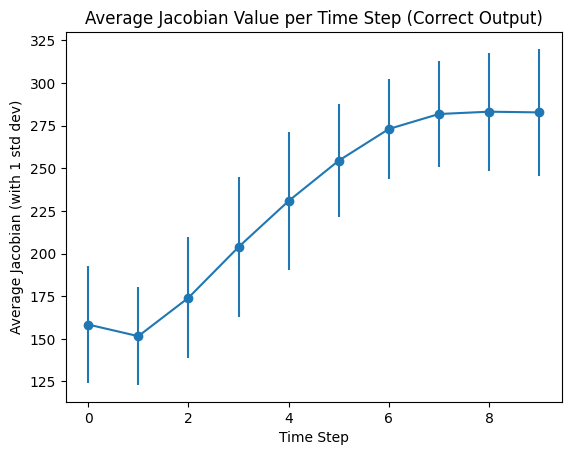

In [49]:
# take the average and standard deviation of the jacobian values for each time step, and plot with error bars
import numpy as np

avgs = []
stds = []
for key, val in jacobian_vals.items():
    val_np = np.array(val)
    avg = val_np.mean()
    std = val_np.std()
    avgs.append(avg)
    stds.append(std)

# plot the average jacobian values with error bars
plt.errorbar(range(len(avgs)), avgs, yerr=stds, fmt='-o')
plt.xlabel("Time Step")
plt.ylabel("Average Jacobian (with 1 std dev)")
plt.title("Average Jacobian Value per Time Step (Correct Output)")
plt.show()

In [33]:
correct_avgs = avgs

In [34]:
correct_avgs

[158.0, 152.0, 173.0, 202.0, 229.0, 254.0, 272.0, 282.0, 284.0, 282.0]

In [55]:
# for each time step in the target sequence, plot the jacobian for the value it should be copying
target_start = 20
seq_length = 10

jacobian_vals = {}
for j in range(64):
    for i in range(seq_length):
        jacobian_val = lookback_norms[j, target_start + i, 21]
        is_correct = correct_output[j, target_start + i - 1]
        if i not in jacobian_vals:
            jacobian_vals[i] = []
        if is_correct == 0.0:
            jacobian_vals[i].append(jacobian_val.item())

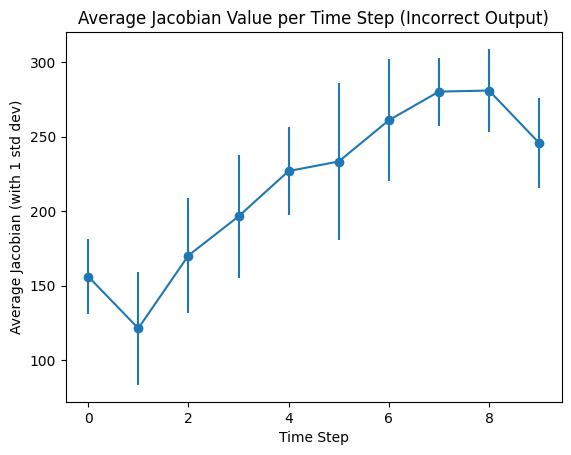

In [56]:
# take the average of the jacobian values for each time step, and plot discontinuously (skip any time steps where jacobian_vals[i] is empty)
plot_timesteps = []
avgs = []
stds = []

for key in sorted(jacobian_vals.keys()):
    val = jacobian_vals[key]
    if len(val) == 0:
        continue  # skip empty lists, so no point is plotted
    val_np = np.array(val)
    avg = val_np.mean()
    std = val_np.std()
    plot_timesteps.append(key)
    avgs.append(avg)
    stds.append(std)

# plot the average jacobian values with error bars for only nonempty times
plt.errorbar(plot_timesteps, avgs, yerr=stds, fmt='-o')
plt.xlabel("Time Step")
plt.ylabel("Average Jacobian (with 1 std dev)")
plt.title("Average Jacobian Value per Time Step (Incorrect Output)")
plt.show()

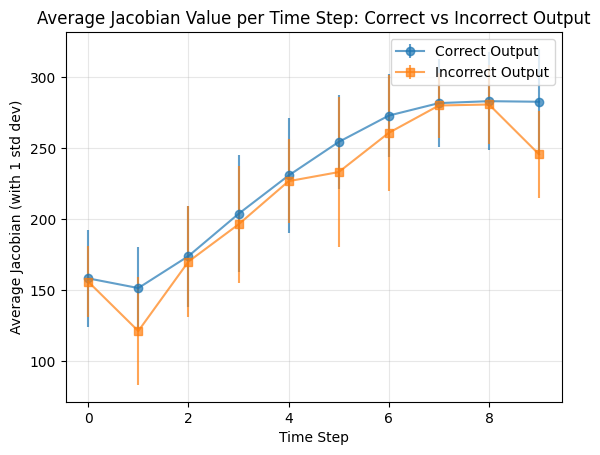

In [54]:
# Plot both correct and incorrect jacobian lookbacks on the same plot with error bars
target_start = 20
seq_length = 10

# Compute correct jacobian values
correct_jacobian_vals = {}
for j in range(64):
    for i in range(seq_length):
        jacobian_val = lookback_norms[j, target_start + i, 21]
        is_correct = correct_output[j, target_start + i - 1]
        if i not in correct_jacobian_vals:
            correct_jacobian_vals[i] = []
        if is_correct == 1.0:
            correct_jacobian_vals[i].append(jacobian_val.item())

# Compute incorrect jacobian values
incorrect_jacobian_vals = {}
for j in range(64):  # Use all batches for consistency
    for i in range(seq_length):
        jacobian_val = lookback_norms[j, target_start + i, 21]
        is_correct = correct_output[j, target_start + i - 1]
        if i not in incorrect_jacobian_vals:
            incorrect_jacobian_vals[i] = []
        if is_correct == 0.0:
            incorrect_jacobian_vals[i].append(jacobian_val.item())

# Compute statistics for correct outputs
correct_plot_timesteps = []
correct_avgs = []
correct_stds = []
for key in sorted(correct_jacobian_vals.keys()):
    val = correct_jacobian_vals[key]
    if len(val) == 0:
        continue
    val_np = np.array(val)
    avg = val_np.mean()
    std = val_np.std()
    correct_plot_timesteps.append(key)
    correct_avgs.append(avg)
    correct_stds.append(std)

# Compute statistics for incorrect outputs
incorrect_plot_timesteps = []
incorrect_avgs = []
incorrect_stds = []
for key in sorted(incorrect_jacobian_vals.keys()):
    val = incorrect_jacobian_vals[key]
    if len(val) == 0:
        continue
    val_np = np.array(val)
    avg = val_np.mean()
    std = val_np.std()
    incorrect_plot_timesteps.append(key)
    incorrect_avgs.append(avg)
    incorrect_stds.append(std)

# Plot both on the same plot
plt.errorbar(correct_plot_timesteps, correct_avgs, yerr=correct_stds, fmt='-o', label='Correct Output', alpha=0.7)
plt.errorbar(incorrect_plot_timesteps, incorrect_avgs, yerr=incorrect_stds, fmt='-s', label='Incorrect Output', alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("Average Jacobian (with 1 std dev)")
plt.title("Average Jacobian Value per Time Step: Correct vs Incorrect Output")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
